<a href="https://colab.research.google.com/github/DengZhengyuan/CFB-filter-model/blob/main/Training_by_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training by TensorFlow 2D



In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Chemical reaction coefficient

### Packages

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.8.2
Mounted at /content/drive


In [2]:
import os 
path = '/content/drive/MyDrive/database_comp'
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/database_comp'

### Data structure and import

In [4]:
column_names = ['nt', 
               'avEs', 'gradXEs', 'gradYEs',
               'gradXP', 'gradYP',
               'avUslip', 'gradXUslip', 'gradYUslip',
               'avOz', 'gradXOz', 'gradYOz',
               'coefHr'
              ]

dir_dataset = './database/dataSet_Hr_5663-slt.csv';
raw_dataset = pd.read_csv(dir_dataset, names=column_names,
                          na_values = "?", comment='\t',
                          sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,nt,avEs,gradXEs,gradYEs,gradXP,gradYP,avUslip,gradXUslip,gradYUslip,avOz,gradXOz,gradYOz,coefHr
1284876,0.174223,-0.173390,-0.441645,1.957423,0.015056,0.090294,-0.162912,0.862956,-0.509480,1.692558,0.020215,-1.678247,0.573422
1284877,-0.791513,-0.853197,-0.026476,-0.054315,0.000946,0.216400,0.132084,0.584071,0.390582,1.636363,-0.348172,-0.156588,0.666976
1284878,1.967733,-0.334541,0.274698,0.463396,-2.871167,-1.030904,2.989692,-1.546551,-1.289201,-0.963152,0.127011,-0.047242,0.655583
1284879,1.967733,1.134116,-1.941494,0.314613,-0.160387,0.262527,-0.617428,0.058685,0.001988,-0.962589,0.787665,-0.131815,0.409220
1284880,0.174223,-0.171376,0.895501,0.324889,-0.064056,0.209285,-0.546373,-0.135485,0.047602,0.239942,-1.090691,0.042415,0.628108


In [5]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('coefHr')
test_labels = test_dataset.pop('coefHr')

### Netwrok structure

In [6]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(36, activation='tanh', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(36, activation='tanh'),
                            layers.Dense(36, activation='tanh'),
                            layers.Dense(36, activation='tanh'),
                            layers.Dense(1, activation='tanh'),
                            ])
  
  initial_learning_rate = 0.0005
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
  
  # loss_huber = tf.keras.losses.Huber(delta=0.2)

  model.compile(loss = 'mape',
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['mape', 'mae', 'mse'])
  return model

In [7]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                468       
                                                                 
 dense_1 (Dense)             (None, 36)                1332      
                                                                 
 dense_2 (Dense)             (None, 36)                1332      
                                                                 
 dense_3 (Dense)             (None, 36)                1332      
                                                                 
 dense_4 (Dense)             (None, 1)                 37        
                                                                 
Total params: 4,501
Trainable params: 4,501
Non-trainable params: 0
_________________________________________________________________


In [8]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.02759441],
       [ 0.02415195],
       [ 0.03377324],
       [-0.32547548],
       [ 0.21902192],
       [ 0.2507221 ],
       [-0.43154496],
       [-0.10483457],
       [-0.54395235],
       [ 0.1504086 ]], dtype=float32)

#### Training

In [ ]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('')
    print('.', end='')

EPOCHS = 250

history = model.fit(
  train_dataset, 
  train_labels,
  epochs=EPOCHS, 
  validation_split = 0.2, 
  verbose=0,
  batch_size=128,
  callbacks=[PrintDot()])


..........
..........
..........
..........
..........
..........
.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAPE of $H_r$ [%]')
  plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
  plt.ylim([2.,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE of $H_r$ [-]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.01, 0.03])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions, s=0.05, alpha=0.2)
plt.xlabel('Actural Values of Hr [-]')
plt.ylabel('Predictions of Hr [-]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
error = (test_predictions - test_labels)/test_labels*100
plt.hist(error, bins = 200)
plt.xlim([-20,20])
plt.xlabel("Prediction Percentage Error [%]")
_ = plt.ylabel("Count")

### Export the model

In [ ]:
model.save('./saved_model/model_hr-5663-slt.h5')

#### Write some results to csv

In [ ]:
# export the actural and prediction values
data_export = np.transpose([test_labels.values, test_predictions])

with open('./post_process/ac-pr-5663-slt.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data_export)

In [ ]:
df = pd.DataFrame(history.history)
df.to_csv('./post_process/history-5663-slt.csv')

## Drag coefficient

### Packages

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.8.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
path = '/content/drive/MyDrive/ML_model-2D_CoLab-0.63'
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/ML_model-2D_CoLab-0.63'

### Data structure and import

In [ ]:
column_names = ['nt',
               'Es','dEsdx','dEsdy', 
               'dPdx','dPdy',
               'UslipY','dUslipYdx','dUslipYdy',
               'coefHd']

dir_dataset = './dataSet_Hd.csv';
raw_dataset = pd.read_csv(dir_dataset, names=column_names,
                          na_values = "?", comment='\t',
                          sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,nt,Es,dEsdx,dEsdy,dPdx,dPdy,UslipY,dUslipYdx,dUslipYdy,coefHd
1967425,0.375485,0.679955,-0.295610,0.057633,-0.083702,-0.709582,2.180156,0.817134,-0.779876,0.670628
1967426,1.942047,-0.652910,0.066809,-0.105500,0.000662,0.015463,0.282451,-0.986664,-0.416844,0.593542
1967427,1.942047,-0.378503,0.198587,-0.603550,0.007094,0.019387,-0.613271,-0.358241,-0.819541,0.770756
1967428,0.375485,-0.614147,-0.073162,-0.047253,0.001086,0.017732,-0.408923,0.341902,-0.365384,0.461198
1967429,0.375485,-0.545802,-0.479216,0.265181,-0.003761,0.012959,0.019092,0.034758,0.987733,0.454433


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('coefHd')
test_labels = test_dataset.pop('coefHd')

### Neural network structure

In [ ]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(240, activation='tanh', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(120, activation='tanh'),
                            layers.Dense(60, activation='tanh'),
                            layers.Dense(60, activation='tanh'),
                            layers.Dense(60, activation='tanh'),
                            layers.Dense(60, activation='tanh'),
                            layers.Dense(1, activation='tanh'),
                            ])
  
  initial_learning_rate = 0.0005
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  loss_huber = tf.keras.losses.Huber(delta=0.25)
  model.compile(loss = loss_huber,
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['mape', 'mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 240)               2400      
                                                                 
 dense_22 (Dense)            (None, 120)               28920     
                                                                 
 dense_23 (Dense)            (None, 60)                7260      
                                                                 
 dense_24 (Dense)            (None, 60)                3660      
                                                                 
 dense_25 (Dense)            (None, 60)                3660      
                                                                 
 dense_26 (Dense)            (None, 60)                3660      
                                                                 
 dense_27 (Dense)            (None, 1)                

In [ ]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.4454963 ],
       [ 0.12311761],
       [ 0.30601335],
       [-0.32357454],
       [ 0.1786518 ],
       [ 0.07808243],
       [-0.66194624],
       [ 0.34981766],
       [ 0.07129984],
       [-0.01453774]], dtype=float32)

#### Training

In [ ]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, 
  train_labels,
  epochs=EPOCHS, 
  validation_split = 0.2, 
  verbose=0,
  batch_size=128,
  callbacks=[PrintDot()])


..........
..........
..........
..........
..........
..........
..........
..........
..........
..........

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mape,mae,mse,val_loss,val_mape,val_mae,val_mse,epoch
90,0.003081,14.270337,0.048621,0.006453,0.003374,14.935577,0.050181,0.007138,90
91,0.003072,14.232590,0.048523,0.006433,0.003297,15.017880,0.049509,0.006977,91
92,0.003057,14.140507,0.048411,0.006399,0.003375,15.289417,0.050515,0.007141,92
93,0.003061,14.187275,0.048481,0.006409,0.003311,14.547668,0.049922,0.007014,93
94,0.003059,14.143671,0.048428,0.006404,0.003281,14.097533,0.049241,0.006955,94
95,0.003056,14.172199,0.048424,0.006398,0.003481,15.260706,0.051273,0.007392,95
96,0.003047,14.149628,0.048357,0.006377,0.003422,15.468778,0.050906,0.007250,96
97,0.003047,14.141892,0.048343,0.006378,0.003421,14.773240,0.051297,0.007251,97
98,0.003047,14.114189,0.048362,0.006377,0.003400,14.364717,0.049891,0.007233,98
99,0.003050,14.116082,0.048381,0.006383,0.003531,14.804256,0.051660,0.007512,99


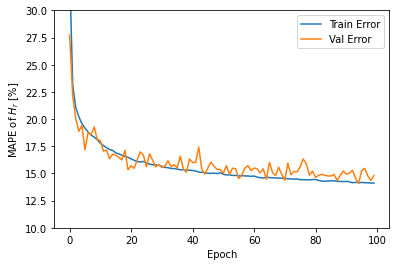

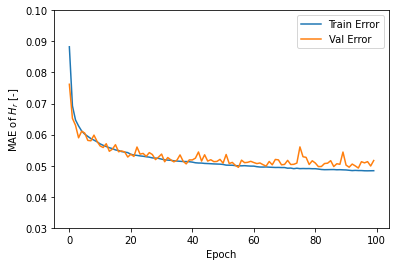

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAPE of $H_r$ [%]')
  plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
  plt.ylim([10.,30.])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE of $H_r$ [-]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.03, 0.1])
  plt.legend()
  plt.show()


plot_history(history)

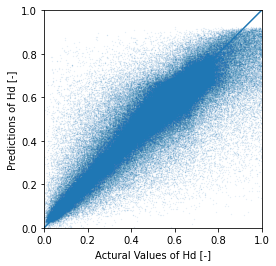

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions, s=0.05, alpha=0.2)
plt.xlabel('Actural Values of Hd [-]')
plt.ylabel('Predictions of Hd [-]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
_ = plt.plot([-100, 100], [-100, 100])

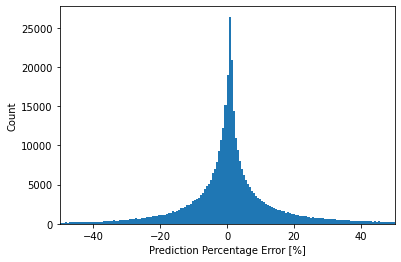

In [ ]:
error = (test_predictions - test_labels)/test_labels*100
plt.hist(error, bins = 50000)
plt.xlim([-50,50])
plt.xlabel("Prediction Percentage Error [%]")
_ = plt.ylabel("Count")

### Export the model

In [ ]:
model.save('./drive/MyDrive/ML_model-2D_CoLab-0.56/saved_model/model_hd')

model.save('./drive/MyDrive/ML_model-2D_CoLab-0.56/saved_model/model_hd.h5')

In [ ]:
# export the actural and prediction values
data_export = np.transpose([test_labels.values, test_predictions])

with open('./drive/MyDrive/ML_model-2D_CoLab-0.56/ac-pr-hd.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data_export)

df = pd.DataFrame(history.history)
df.to_csv('./drive/MyDrive/ML_model-2D_CoLab-0.56/history_hd.csv')

## Model loading test

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

import tensorflow as tf

print(tf.__version__)

# access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.8.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reaction

In [ ]:
column_names = ['nt', 
               'avEs', 'gradXEs', 'gradYEs',
               'avUslip', 'gradXUslip', 'gradYUslip',
               'avOz', 'gradXOz', 'gradYOz',
               'coefHr'
              ]

dir_dataset = './drive/MyDrive/ML_model_CoLab-2/dataSet_Hr_27-40.csv';
raw_dataset = pd.read_csv(dir_dataset, names=column_names,
                          na_values = "?", comment='\t',
                          sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,nt,avEs,gradXEs,gradYEs,avUslip,gradXUslip,gradYUslip,avOz,gradXOz,gradYOz,coefHr
903454,-0.654033,-0.246491,0.235358,0.833028,0.742423,0.402253,-0.889904,-1.105819,0.059771,0.059192,0.662899
903455,-0.654033,1.945756,0.783242,2.767775,-0.736905,-0.003636,-0.061013,-0.906431,-1.718316,-4.832333,0.467114
903456,-0.654033,-0.703575,-0.015649,0.107843,-0.023702,-0.093658,-0.524788,-1.647853,0.126714,0.172214,0.634557
903457,-0.654033,1.562631,1.206142,-0.719028,-0.652594,-0.258675,0.344689,-1.517102,0.910571,0.351707,0.646987
903458,-0.654033,-0.040198,-0.435613,1.566825,0.652811,0.259045,-0.386838,-0.107130,-0.240405,0.112327,0.672528


In [ ]:
new_model = tf.keras.models.load_model('./drive/MyDrive/ML_model_CoLab-2/saved_model/model_hr_27-40.h5')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                660       
                                                                 
 dense_1 (Dense)             (None, 50)                3050      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 30)                1530      
                                                                 
 dense_4 (Dense)             (None, 20)                620       
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dense_6 (Dense)             (None, 1)                 2

In [ ]:
test_dataset = dataset.sample(frac=0.2,random_state=0)
test_labels = test_dataset.pop('coefHr')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


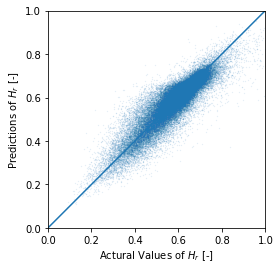

In [ ]:
test_predictions = new_model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions, s=0.05, alpha=0.2)
plt.xlabel('Actural Values of $H_r$ [-]')
plt.ylabel('Predictions of $H_r$ [-]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
_ = plt.plot([-100, 100], [-100, 100])

# Training by TensorFlow 3D

## Chemical reaction coefficient

### Packages

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.8.2
Mounted at /content/drive


### Data structure and import

In [ ]:
column_names = ['nt', 
               'avEs', 'gradXEs', 'gradYEs',
               'avUslip', 'gradXUslip', 'gradYUslip',
               'avOz', 'gradXOz', 'gradYOz',
               'coefHr'
              ]

dir_dataset = './drive/MyDrive/ML_model-3D_CoLab/dataSet_3DHr_60-120.csv';
raw_dataset = pd.read_csv(dir_dataset, names=column_names,
                          na_values = "?", comment='\t',
                          sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,nt,avEs,gradXEs,gradYEs,avUslip,gradXUslip,gradYUslip,avOz,gradXOz,gradYOz,coefHr
475465,-0.713943,-0.323576,-0.500245,0.848757,-0.505665,0.014325,-0.110021,-1.259383,0.009354,-0.544078,0.660954
475466,2.611537,1.253580,0.659122,-0.286811,-0.326813,0.576854,0.363816,-1.671585,0.780844,-0.045013,0.630576
475467,-0.713943,1.090198,0.353064,0.754669,-0.766581,0.235330,1.213936,-0.228424,0.397944,3.097976,0.649300
475468,1.503044,-0.541039,-0.010916,-0.251871,-0.850127,-0.010140,0.077967,-0.435970,-0.078164,-0.319302,0.657419
475469,-0.713943,-0.839837,-0.607195,-1.181715,-0.527263,-0.280809,0.759705,1.324302,-0.013587,0.396389,0.646217


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('coefHr')
test_labels = test_dataset.pop('coefHr')

### Netwrok structure

In [ ]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(60, activation='tanh', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(50, activation='tanh'),
                            layers.Dense(50, activation='tanh'),
                            layers.Dense(30, activation='tanh'),
                            layers.Dense(20, activation='tanh'),
                            layers.Dense(20, activation='tanh'),
                            layers.Dense(1, activation='tanh'),
                            ])
  
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(loss = 'mape',
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['mape', 'mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 60)                660       
                                                                 
 dense_22 (Dense)            (None, 50)                3050      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 30)                1530      
                                                                 
 dense_25 (Dense)            (None, 20)                620       
                                                                 
 dense_26 (Dense)            (None, 20)                420       
                                                                 
 dense_27 (Dense)            (None, 1)                

In [ ]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.11516289],
       [ 0.07857443],
       [-0.02048218],
       [-0.07624497],
       [ 0.01134573],
       [ 0.12214134],
       [ 0.26827163],
       [ 0.38927975],
       [ 0.0088293 ],
       [-0.11281744]], dtype=float32)

In [ ]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('')
    print('.', end='')

EPOCHS = 30

history = model.fit(
  train_dataset, 
  train_labels,
  epochs=EPOCHS, 
  validation_split = 0.2, 
  verbose=0,
  batch_size=128,
  callbacks=[PrintDot()])


..........
..........
..........

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mape,mae,mse,val_loss,val_mape,val_mae,val_mse,epoch
20,3.613134,3.613134,0.025052,0.002360,3.672601,3.672601,0.025438,0.002462,20
21,3.599426,3.599426,0.024959,0.002345,3.728772,3.728772,0.025694,0.002395,21
22,3.590313,3.590313,0.024884,0.002334,3.752095,3.752095,0.025944,0.002459,22
23,3.582983,3.582983,0.024840,0.002327,3.644929,3.644929,0.025264,0.002429,23
24,3.574459,3.574459,0.024779,0.002317,3.679452,3.679452,0.025236,0.002364,24
25,3.571443,3.571443,0.024759,0.002312,3.650684,3.650684,0.025346,0.002460,25
26,3.559731,3.559731,0.024680,0.002309,3.674580,3.674580,0.025380,0.002395,26
27,3.556443,3.556443,0.024644,0.002297,3.680385,3.680385,0.025491,0.002428,27
28,3.546199,3.546199,0.024581,0.002291,3.634189,3.634189,0.025005,0.002360,28
29,3.541419,3.541419,0.024550,0.002286,3.657657,3.657657,0.025222,0.002408,29


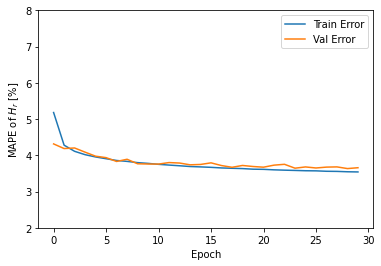

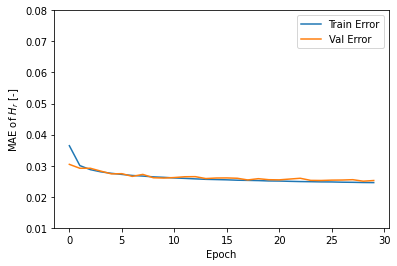

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAPE of $H_r$ [%]')
  plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
  plt.ylim([2.,8])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE of $H_r$ [-]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.01, 0.08])
  plt.legend()
  plt.show()


plot_history(history)

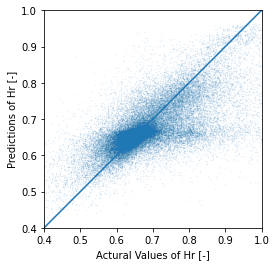

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions, s=0.05, alpha=0.2)
plt.xlabel('Actural Values of Hr [-]')
plt.ylabel('Predictions of Hr [-]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0.4,1])
plt.ylim([0.4,1])
_ = plt.plot([-100, 100], [-100, 100])

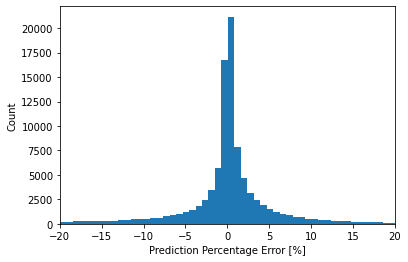

In [ ]:
error = (test_predictions - test_labels)/test_labels*100
plt.hist(error, bins = 200)
plt.xlim([-20,20])
plt.xlabel("Prediction Percentage Error [%]")
_ = plt.ylabel("Count")

### Export the model

In [ ]:
# model.save('./drive/MyDrive/ML_model_CoLab-2/saved_model/model_hr_27-40')

model.save('./drive/MyDrive/ML_model-3D_CoLab/saved_model/model_3Dhr_60-120.h5')

## Drag coefficient

### Packages

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

2.8.2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data structure and import

In [ ]:
column_names = ['nt',
               'Es','dEsdx','dEsdy', 
               'dPdx','dPdy',
               'UslipY','dUslipYdx','dUslipYdy',
               'coefHd']

dir_dataset = './drive/MyDrive/ML_model-3D_CoLab/dataSet_3DHd_60-120.csv';
raw_dataset = pd.read_csv(dir_dataset, names=column_names,
                          na_values = "?", comment='\t',
                          sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,nt,Es,dEsdx,dEsdy,dPdx,dPdy,UslipY,dUslipYdx,dUslipYdy,coefHd
475465,-0.713943,-0.323576,-0.500245,0.848757,-0.002540,-0.168391,-0.517605,0.017202,-0.143246,0.367483
475466,2.611537,1.253580,0.659122,-0.286811,-0.005784,-2.364858,-0.262984,0.530910,0.308037,0.226941
475467,-0.713943,1.090198,0.353064,0.754669,-0.002368,0.380159,-0.672997,0.280569,1.073632,0.299895
475468,1.503044,-0.541039,-0.010916,-0.251871,-0.002210,0.030233,-0.745238,-0.010397,0.078710,0.389981
475469,-0.713943,-0.839837,-0.607195,-1.181715,-0.002210,0.029521,-0.492880,-0.209807,0.699367,0.319990


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('coefHd')
test_labels = test_dataset.pop('coefHd')

### Neural network structure

In [ ]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(60, activation='tanh', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(50, activation='tanh'),
                            layers.Dense(50, activation='tanh'),
                            layers.Dense(30, activation='tanh'),
                            layers.Dense(20, activation='tanh'),
                            layers.Dense(20, activation='tanh'),
                            layers.Dense(1, activation='tanh'),
                            ])
  
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(loss = 'mape',
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=['mape', 'mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 60)                600       
                                                                 
 dense_29 (Dense)            (None, 50)                3050      
                                                                 
 dense_30 (Dense)            (None, 50)                2550      
                                                                 
 dense_31 (Dense)            (None, 30)                1530      
                                                                 
 dense_32 (Dense)            (None, 20)                620       
                                                                 
 dense_33 (Dense)            (None, 20)                420       
                                                                 
 dense_34 (Dense)            (None, 1)                

In [ ]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.49263003],
       [ 0.44139186],
       [ 0.17685522],
       [-0.5967349 ],
       [ 0.5704733 ],
       [-0.31259534],
       [-0.5134944 ],
       [ 0.23379552],
       [-0.16741098],
       [-0.58302474]], dtype=float32)

#### Training

In [ ]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('')
    print('.', end='')

EPOCHS = 70

history = model.fit(
  train_dataset, 
  train_labels,
  epochs=EPOCHS, 
  validation_split = 0.2, 
  verbose=0,
  batch_size=128,
  callbacks=[PrintDot()])


..........
..........
..........
..........
..........
..........
..........

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)

,loss,mape,mae,mse,val_loss,val_mape,val_mae,val_mse,epoch
60,17.878422,17.878422,0.072072,0.015445,18.304565,18.304565,0.071317,0.015011,60
61,17.881847,17.881847,0.071973,0.015410,18.416985,18.416985,0.073745,0.016298,61
62,17.925987,17.925987,0.072157,0.015440,18.088467,18.088467,0.071042,0.015152,62
63,17.869232,17.869232,0.072008,0.015447,18.427942,18.427942,0.073527,0.015918,63
64,17.854488,17.854488,0.071926,0.015415,18.173820,18.173820,0.072495,0.015641,64
65,17.826820,17.826820,0.071854,0.015379,19.432844,19.432844,0.077573,0.015928,65
66,17.837383,17.837383,0.071933,0.015412,18.456806,18.456806,0.071903,0.014976,66
67,17.827318,17.827318,0.071780,0.015333,18.245377,18.245377,0.073971,0.016253,67
68,17.843328,17.843328,0.071894,0.015395,17.918411,17.918411,0.071786,0.015579,68
69,17.810619,17.810619,0.071769,0.015337,18.057129,18.057129,0.072829,0.016070,69


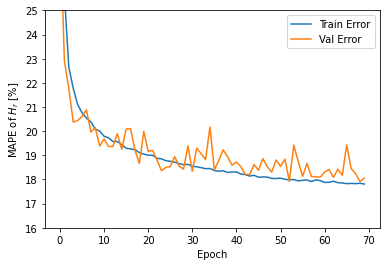

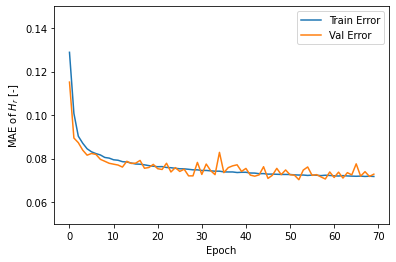

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAPE of $H_r$ [%]')
  plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
  plt.ylim([16.,25.])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MAE of $H_r$ [-]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.05, 0.15])
  plt.legend()
  plt.show()


plot_history(history)

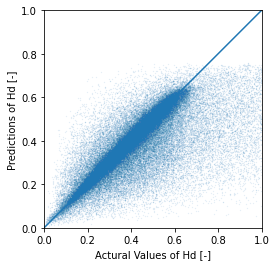

In [ ]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions, s=0.05, alpha=0.2)
plt.xlabel('Actural Values of Hd [-]')
plt.ylabel('Predictions of Hd [-]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
_ = plt.plot([-100, 100], [-100, 100])

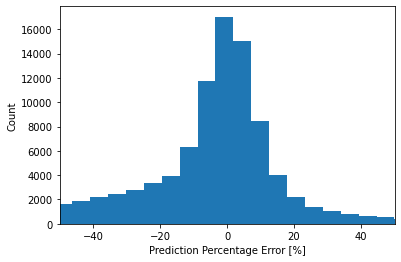

In [ ]:
error = (test_predictions - test_labels)/test_labels*100
plt.hist(error, bins = 200)
plt.xlim([-50,50])
plt.xlabel("Prediction Percentage Error [%]")
_ = plt.ylabel("Count")

### Export the model

In [ ]:
# model.save('./drive/MyDrive/ML_model_CoLab-2/saved_model/model_hd_27-40')

model.save('./drive/MyDrive/ML_model-3D_CoLab/saved_model/model_3Dhd_60-120.h5')